# Векторные модели. Word2Vec

Одной из самых известных моделей для работы с дистрибутивной семантикой является word2vec. Технология основана на нейронной сети, предсказывающей вероятность встретить слово в заданном контексте. Этот инструмент был разработан группой исследователей Google в 2013 году, руководителем проекта был Томаш Миколов (сейчас работает в Facebook). Вот две самые главные статьи:

+ [Efficient Estimation of Word Representations inVector Space](https://arxiv.org/pdf/1301.3781.pdf)
+ [Distributed Representations of Words and Phrases and their Compositionality](https://arxiv.org/abs/1310.4546)

Полученные таким образом вектора называются распределенными представлениями слов, или **эмбеддингами**.

#### Как это обучается?

Мы задаём вектор для каждого слова с помощью матрицы $w$ и вектор контекста с помощью матрицы $W$. По сути, word2vec является обобщающим названием для двух архитектур Skip-Gram и Continuous Bag-Of-Words (CBOW).

+ **CBOW** предсказывает текущее слово, исходя из окружающего его контекста.

+ **Skip-gram**, наоборот, использует текущее слово, чтобы предугадывать окружающие его слова.

![CBOW&SkipGram](https://www.researchgate.net/profile/Metin-Bilgin/publication/320829283/figure/fig2/AS:759096500318213@1557994117366/Word2Vec-CBOW-and-Skip-gram-There-are-two-different-methods-in-the-Word2Vec-algorithm.png)

#### Как это работает?

Word2vec принимает большой текстовый корпус в качестве входных данных и сопоставляет каждому слову вектор, выдавая координаты слов на выходе. Сначала он создает словарь, «обучаясь» на входных текстовых данных, а затем вычисляет векторное представление слов. Векторное представление основывается на контекстной близости: слова, встречающиеся в тексте рядом с одинаковыми словами (а следовательно, согласно дистрибутивной гипотезе, имеющие схожий смысл), в векторном представлении будут иметь близкие координаты векторов-слов. Для вычисления близости слов используется косинусное расстояние между их векторами.

Ещё про механику с картинками [тут](https://habr.com/ru/post/446530/)

Несколько интересных статей по дистрибутивной семантике:

* [Turney and Pantel 2010](https://jair.org/index.php/jair/article/view/10640)
* [Lenci 2018](https://www.annualreviews.org/doi/abs/10.1146/annurev-linguistics-030514-125254?journalCode=linguistics)
* [Smith 2019](https://arxiv.org/pdf/1902.06006.pdf)
* [Pennington et al. 2014](https://www.aclweb.org/anthology/D14-1162/)
* [Faruqui et al. 2015](https://www.aclweb.org/anthology/N15-1184/)

#### Gensim

Использовать предобученную модель эмбеддингов или обучить свою можно с помощью библиотеки `gensim`. Вот ее [документация](https://radimrehurek.com/gensim/models/word2vec.html). Вообще-то `gensim` — библиотека для тематического моделирования текстов, но один из компонентов в ней — реализация на python алгоритмов из библиотеки word2vec (которая в оригинале была написана на C++).

In [ ]:
import re
import gensim
import logging
import urllib.request
from gensim.models import word2vec

#### Как использовать готовую модель

#### RusVectōrēs

На сайте RusVectōrēs (https://rusvectores.org/ru/) собраны предобученные на различных данных модели для русского языка, а также можно поискать наиболее близкие слова к заданному, посчитать семантическую близость нескольких слов и порешать примеры с помощью «калькулятором семантической близости».

Для других языков также можно найти предобученные модели — например, модели [fastText](https://fasttext.cc/docs/en/english-vectors.html) и [GloVe](https://nlp.stanford.edu/projects/glove/)

#### Работа с моделью

Модели word2vec бывают разных форматов:

+ .vec.gz — обычный файл
+ .bin.gz — бинарник

Загружаются они с помощью одного и того же гласса `KeyedVectors`, меняется только параметр `binary` у функции `load_word2vec_format`.

Если же эмбеддинги обучены не с помощью word2vec, то для загрузки нужно использовать функцию `load`. Т.е. для загрузки предобученных эмбеддингов `glove`, `fasttext`, `bpe` и любых других нужна именно она.

Скачаем с RusVectōrēs модель для русского языка, обученную на НКРЯ образца 2015 г.

In [ ]:
urllib.request.urlretrieve("http://rusvectores.org/static/models/rusvectores2/ruscorpora_mystem_cbow_300_2_2015.bin.gz", "ruscorpora_mystem_cbow_300_2_2015.bin.gz")

('ruscorpora_mystem_cbow_300_2_2015.bin.gz',
 <http.client.HTTPMessage at 0x7f9c91cf0250>)

In [ ]:
m = 'ruscorpora_mystem_cbow_300_2_2015.bin.gz'

if m.endswith('.vec.gz'):
    model = gensim.models.KeyedVectors.load_word2vec_format(m, binary=False)
elif m.endswith('.bin.gz'):
    model = gensim.models.KeyedVectors.load_word2vec_format(m, binary=True)
else:
    model = gensim.models.KeyedVectors.load(m)

In [ ]:
words = ['хороший_A', 'плохой_A', 'ужасный_A','жуткий_A', 'страшный_A', 'красный_A', 'синий_A', 'толстый_A', 'тонкий_A']

Частеречные тэги нужны, поскольку это специфика скачанной модели - она была натренирована на словах, аннотированных их частями речи (и лемматизированных). NB! В названиях моделей на `rusvectores` указано, какой тегсет они используют (mystem, upos и т.д.)

Попросим у модели 10 ближайших соседей для каждого слова и коэффициент косинусной близости для каждого:


In [ ]:
for word in words:
    # есть ли слово в модели? 
    if word in model:
        print(word)
        # смотрим на вектор слова (его размерность 300, смотрим на первые 10 чисел)
        print(model[word][:10])
        # выдаем 10 ближайших соседей слова:
        for i in model.most_similar(positive=[word], topn=10):
            # слово + коэффициент косинусной близости
            print(i[0], i[1])
        print('\n')
    else:
        # Увы!
        print('Увы, слова "%s" нет в модели!' % word)

хороший_A
[ 0.00722357 -0.00361956  0.1272455   0.06584469  0.00709477 -0.02014845
 -0.02056034  0.01321563  0.13692418 -0.09624264]
плохой_A 0.7463520765304565
неплохой_A 0.6708558797836304
отличный_A 0.6633436679840088
превосходный_A 0.6079519987106323
замечательный_A 0.586450457572937
недурной_A 0.5322482585906982
отменный_A 0.5168066024780273
прекрасный_A 0.4982393980026245
посредственный_A 0.49099433422088623
приличный_A 0.48622459173202515


плохой_A
[-0.05218472  0.0307817   0.1459371   0.0151835   0.06219714  0.01153753
 -0.01169093  0.01818374  0.0955373  -0.10191503]
хороший_A 0.7463520765304565
дурной_A 0.6186875104904175
скверный_A 0.6014161109924316
отличный_A 0.5226833820343018
посредственный_A 0.5061030983924866
неважный_A 0.5021152496337891
неплохой_A 0.49169060587882996
никудышный_A 0.48035892844200134
ухудшать_V 0.43680477142333984
плохо_ADV 0.4314875304698944


ужасный_A
[-0.05553271 -0.03172469  0.01998607  0.00171507 -0.00935555 -0.0296017
  0.05394973  0.01597532 

Сравним соседей слова "корова" в дистрибутивной модели с самыми близкими синсетами к синсету "cow.n.01" в WordNet:

In [ ]:
print(model.most_similar('корова_S', topn=10))

[('коза_S', 0.7425954341888428), ('овца_S', 0.7238737940788269), ('баран_S', 0.6863292455673218), ('скотина_S', 0.6680464744567871), ('свинья_S', 0.652885377407074), ('теленок_S', 0.649688720703125), ('стадо_S', 0.642794668674469), ('скот_S', 0.616152822971344), ('недаивать_V', 0.6145889759063721), ('бык_S', 0.5990427732467651)]


In [ ]:
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
cow_synset = wn.synset('cow.n.01')
similarities = {}
for synset in wn.all_synsets('n'):
  sim = cow_synset.path_similarity(synset)
  similarities[synset.name()] = sim

In [ ]:
sorted_sim = sorted(similarities, key=lambda i: similarities[i], reverse=True)
for item in sorted_sim[:10]:
  print(item, similarities[item])

cow.n.01 1.0
cattle.n.01 0.5
springer.n.02 0.5
heifer.n.01 0.5
bovine.n.01 0.3333333333333333
ox.n.01 0.3333333333333333
stirk.n.01 0.3333333333333333
bullock.n.02 0.3333333333333333
bull.n.01 0.3333333333333333
beef.n.01 0.3333333333333333


Находим косинусную близость пары слов:

In [ ]:
print(model.similarity('плохой_A', 'хороший_A'))

0.74635214


In [ ]:
print(model.similarity('плохой_A', 'синий_A'))

-0.12778337


In [ ]:
print(model.similarity('плохой_A', 'мальчик_S'))

-0.041556165


Пропорция

+ positive — вектора, которые мы складываем
+ negative — вектора, которые вычитаем

In [ ]:
print(model.most_similar(positive=['плохой_A', 'ужасный_A'], negative=['хороший_A'])[0][0])

страшный_A


Найди лишнее!

In [ ]:
print(model.doesnt_match('плохой_A хороший_A ужасный_A страшный_A'.split()))

хороший_A


In [ ]:
for word, score in model.most_similar(positive=['ужасно_ADV'], negative=['плохой_A']):
    print(f'{score:.4}\t{word}')

0.5575	безумно_ADV
0.4791	безмерно_ADV
0.4536	жутко_ADV
0.4472	невероятно_ADV
0.4394	очень_ADV
0.4364	чертовски_ADV
0.4231	страшно_ADV
0.4124	необычайно_ADV
0.4119	нестерпимо_ADV
0.4005	необыкновенно_ADV


**Визуализация**

Можно использовать разные методы того, как преобразовать векторы так, чтобы можно было их поместить на двумерное пространство, например, с помощью PCA. В зависимости от того, относительно какого набора слов вы пытаетесь найти оптимальное отображение на двумерное пространство, у вас могут получаться разные результаты

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
words = ['хороший_A', 'плохой_A', 'ужасный_A','жуткий_A', 'страшный_A', 'красный_A', 'синий_A']
X = model[words]

На списке конкретных слов

In [ ]:
pca = PCA(n_components=2)
coords = pca.fit_transform(X)

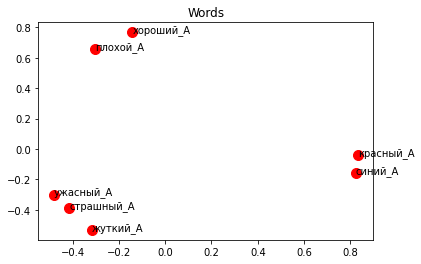

In [ ]:
plt.scatter(coords[:, 0], coords[:, 1], color='red', s=100)
plt.title('Words')

for i, word in enumerate(words):
    plt.annotate(word, xy=(coords[i, 0], coords[i, 1]), size=10)
plt.show()

На всех словах в модели

In [ ]:
pca = PCA(n_components=2)
pca.fit(model[list(model.vocab)])
coords = pca.transform(model[words])

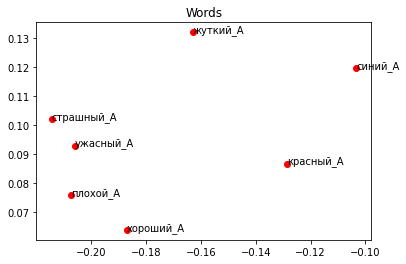

In [ ]:
plt.scatter(coords[:, 0], coords[:, 1], color='red')
plt.title('Words')

for i, word in enumerate(words):
    plt.annotate(word, xy=(coords[i, 0], coords[i, 1]))
plt.show()

#### Как обучить свою модель

NB! Обратите внимание, что тренировка модели не включает препроцессинг! Это значит, что избавляться от пунктуации, приводить слова к нижнему регистру, лемматизировать их, проставлять частеречные теги придется до тренировки модели (если, конечно, это необходимо для вашей задачи). Т.е. в каком виде слова будут в исходном тексте, в таком они будут и в модели.

Поскольку иногда тренировка модели занимает много времени, то можно ещё вести лог событий, чтобы понимать, что на каком этапе происходит.

In [ ]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

На вход модели даем текстовый файл, каждое предложение на отдельной строчке. Вот игрушечный пример с текстом «Бедной Лизы». Он заранее очищен от пунктуации, приведен к нижнему регистру и лемматизирован.

In [ ]:
f = 'liza_lem.txt'
data = gensim.models.word2vec.LineSentence(f)

Инициализируем модель. Основные параметры:

+ данные должны быть итерируемым объектом
+ size — размер вектора,
+ window — размер окна наблюдения,
+ min_count — мин. частотность слова в корпусе,
+ sg — используемый алгоритм обучения (0 — CBOW, 1 — Skip-gram),
+ sample — порог для downsampling'a высокочастотных слов,
+ workers — количество потоков,
+ alpha — learning rate,
+ iter — количество итераций,
+ max_vocab_size — позволяет выставить ограничение по памяти при создании словаря (т.е. если ограничение привышается, то низкочастотные слова будут выбрасываться). Для сравнения: 10 млн слов = 1Гб RAM.

In [ ]:
%time model_liza = gensim.models.Word2Vec(data, size=300, window=5, min_count=2, iter=20)

2019-10-17 20:34:43,388 : INFO : collecting all words and their counts
2019-10-17 20:34:43,396 : WARNING : this function is deprecated, use smart_open.open instead
2019-10-17 20:34:43,407 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-10-17 20:34:43,415 : INFO : collected 1213 word types from a corpus of 3109 raw words and 392 sentences
2019-10-17 20:34:43,420 : INFO : Loading a fresh vocabulary
2019-10-17 20:34:43,427 : INFO : effective_min_count=2 retains 478 unique words (39% of original 1213, drops 735)
2019-10-17 20:34:43,431 : INFO : effective_min_count=2 leaves 2374 word corpus (76% of original 3109, drops 735)
2019-10-17 20:34:43,439 : INFO : deleting the raw counts dictionary of 1213 items
2019-10-17 20:34:43,441 : INFO : sample=0.001 downsamples 83 most-common words
2019-10-17 20:34:43,445 : INFO : downsampling leaves estimated 1817 word corpus (76.6% of prior 2374)
2019-10-17 20:34:43,450 : INFO : estimated required memory for 478 words and 3

2019-10-17 20:34:56,958 : WARNING : this function is deprecated, use smart_open.open instead
2019-10-17 20:34:56,995 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-17 20:34:57,002 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-17 20:34:58,142 : INFO : EPOCH 14 - PROGRESS: at 100.00% examples, 1593 words/s, in_qsize 0, out_qsize 1
2019-10-17 20:34:58,146 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-17 20:34:58,150 : INFO : EPOCH - 14 : training on 3109 raw words (1836 effective words) took 1.2s, 1581 effective words/s
2019-10-17 20:34:58,159 : WARNING : this function is deprecated, use smart_open.open instead
2019-10-17 20:34:58,192 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-17 20:34:58,203 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-17 20:34:59,313 : INFO : EPOCH 15 - PROGRESS: at 100.00% examples, 1600 words/s, in_qsize 0, out_qsize 1
201

Wall time: 21.4 s


Можно нормализовать вектора, тогда модель будет занимать меньше RAM. Однако после этого её нельзя дотренировывать. Здесь используется L2-нормализация: вектора нормализуются так, что если сложить квадраты всех элементов вектора, в сумме получится 1.

In [ ]:
model_liza.init_sims(replace=True)
model_path = "liza.bin"

print("Saving model...")
model_liza.wv.save_word2vec_format(model_path, binary=True)

2019-10-17 20:35:04,821 : INFO : precomputing L2-norms of word weight vectors
2019-10-17 20:35:04,870 : INFO : storing 478x300 projection weights into liza.bin
2019-10-17 20:35:04,876 : WARNING : this function is deprecated, use smart_open.open instead


Saving model...


Смотрим, сколько в модели слов:

In [ ]:
print(len(model_liza.wv.vocab))

478


In [ ]:
print(sorted([w for w in model_liza.wv.vocab]))

['анюта', 'армия', 'ах', 'барин', 'бедный', 'белый', 'берег', 'березовый', 'беречь', 'бесчисленный', 'благодарить', 'бледный', 'блеснуть', 'блестящий', 'близ', 'бог', 'богатый', 'большой', 'бояться', 'брать', 'бросать', 'бросаться', 'бывать', 'быть', 'важный', 'ввечеру', 'вдова', 'велеть', 'великий', 'великолепный', 'верить', 'верно', 'весело', 'веселый', 'весна', 'вести', 'весь', 'весьма', 'ветвь', 'ветер', 'вечер', 'взглядывать', 'вздох', 'вздыхать', 'взор', 'взять', 'вид', 'видеть', 'видеться', 'видный', 'вместе', 'вода', 'возвращаться', 'воздух', 'война', 'воображать', 'воображение', 'воспоминание', 'восторг', 'восхищаться', 'время', 'все', 'вслед', 'вставать', 'встречаться', 'всякий', 'высокий', 'выть', 'выходить', 'глаз', 'глубокий', 'гнать', 'говорить', 'год', 'голос', 'гора', 'горе', 'горестный', 'горлица', 'город', 'горький', 'господь', 'гром', 'грусть', 'давать', 'давно', 'далее', 'дверь', 'движение', 'двор', 'девушка', 'дело', 'день', 'деньги', 'деревня', 'деревянный', 'деся

И чему же мы ее научили? Попробуем оценить модель вручную, порешав примеры. Несколько дано ниже, попробуйте придумать свои.

In [ ]:
model_liza.wv.most_similar(positive=["смерть", "любовь"], negative=["печальный"], topn=1)

[('свой', 0.9896478056907654)]

In [ ]:
model_liza.wv.most_similar("любовь", topn=3)

[('свой', 0.9973198175430298),
 ('лиза', 0.9972617626190186),
 ('сей', 0.9968301057815552)]

In [ ]:
model_liza.wv.similarity("лиза", "эраст")

0.9977509

In [ ]:
model_liza.wv.similarity("лиза", "лиза")

0.99999994

In [ ]:
model_liza.wv.doesnt_match("скорбь грусть слеза улыбка".split())

'грусть'

In [ ]:
model_liza.wv.words_closer_than("лиза", "эраст")

['свой',
 'который',
 'мочь',
 'сказать',
 'сей',
 'сердце',
 'мой',
 'любить',
 'мать',
 'рука',
 'друг',
 'часто',
 'один',
 'душа',
 'смотреть',
 'лизин',
 'взять',
 'чистый',
 'берег']

#### Параметры варьирования

1) препроцессинг -- лемматизировать или нет

2) размер корпуса -- чем больше, тем лучше, но! не для семантических задач -- для них важнее качество

3) размер словаря

4) negative samples

5) количество итераций

6) длина вектора -- 100-300 (судя по всему, >300 не сильно улучшает результаты)

7) длина окна -- для синтаксических задач, примерно 4, для семантических задач, большое окно, 8, 10.

Хорошая статья про сравнение моделей с варьированием параметров: https://www.aclweb.org/anthology/D14-1162.pdf